In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
%matplotlib inline

In [99]:
from pandas import DataFrame, concat
from scipy.stats import norm
from scipy.stats import spearmanr
from tqdm import tqdm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
n_simulations = 1000      # Number of simulations
n_agents = 1000           # Number of agents
n_trials = 100            # Number of task trials
n_items = 20              # Number of self-report items
samp_size = 100

## Define task parameters.
phi_mu = 0.80
phi_sd = 0.05

## Define self-report parameters.
thresholds = [
    [-1.2, 0.0, 1.2],     # Symmetric
    [-1.2, 0.0, 1.2],     # Symmetric
    [-0.2, 1.0, 2.2],     # Right-skewed
    [-0.2, 1.0, 2.2]      # Right-skewed
]

## Define careless responding parameters.
careless = [0.0,0.15,0.0,0.15]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
score = []
corr = []

for i, (tau, frac) in enumerate(zip(thresholds, careless)):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Simulate C/IE trait.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Define number of participants.
    n_careless = int(n_agents * frac)
    n_careful  = int(n_agents * (1 - frac))
    
    ## Generate lapse rates (binarized).
    pi = np.concatenate([np.zeros(n_careful), np.ones(n_careless)])

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Simulate task behavior.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Generate latent traits (accurarcies).
    phi = np.random.normal(phi_mu, phi_sd, n_agents)

    ## Add clipping (prevent phi > 1).
    phi = np.where(phi > 1, 1, phi)

    ## Incorporate lapse rates.
    phi = (1-pi) * phi + (pi / 2)

    ## Simulate accuracy.
    y_task = np.random.binomial(n_trials, phi) / n_trials
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Simulate self-report behavior.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Generate latent traits.
    psi = np.random.normal(0, 1, n_agents)

    ## Convert to endorsement propensities.
    psi = norm(0,1).cdf(np.subtract.outer(tau, psi)).T
    psi = np.column_stack([np.zeros(n_agents), psi, np.ones(n_agents)])
    psi = np.diff(psi)

    ## Incorporate lapse rates.
    psi = (1 - pi[:,np.newaxis]) * psi + pi[:,np.newaxis] / psi.shape[1]

    ## Simulate sum scores.
    f = lambda p: np.random.multinomial(1,p,n_items)
    y_sr = np.apply_along_axis(f, 1, psi).argmax(axis=-1).mean(axis=-1) / len(tau)    
    
    ## Store scores.
    score.append(DataFrame(np.column_stack([np.ones(n_agents) * i, y_sr, pi]),
                 columns=['cond','score','pi']))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Correlation analysis.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Preallocate space.
    rvals = np.zeros(n_simulations)
    pvals = np.zeros(n_simulations)
    
    for j in tqdm(range(n_simulations)):
        
        ## Sample participants.
        ix = np.concatenate([
            np.random.choice(np.where(pi==0)[0], int(samp_size * (1-frac))),
            np.random.choice(np.where(pi==1)[0], int(samp_size * frac))
        ])
        
        ## Compute and store correlations.
        rvals[j], pvals[j] = spearmanr(y_task[ix], y_sr[ix])
    
    ## Store correlations.
    corr.append(DataFrame(np.column_stack([np.ones(n_simulations)*i, rvals, pvals]),
                          columns=['cond','rval','pval']))
    
## Concatenate scores.
score = concat(score)
corr = concat(corr)

100%|██████████| 1000/1000 [00:00<00:00, 1194.45it/s]


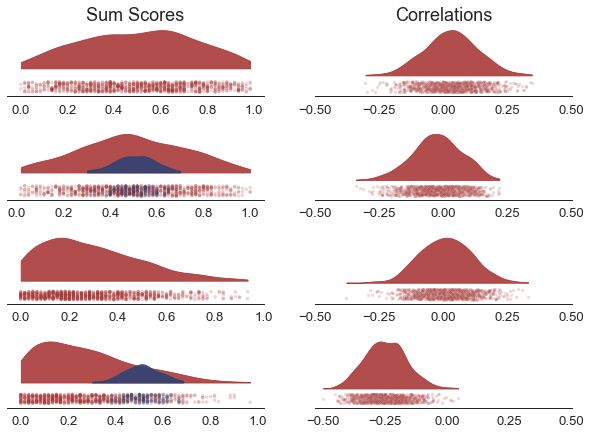

In [137]:
fig, axes = plt.subplots(4,2,figsize=(8,7))
score['y'] = np.random.uniform(-0.9,-0.5,score.shape[0])
corr['y'] = np.random.uniform(-1.4,-0.5,score.shape[0])

for i in range(4):

    ## Define order / palette.
    if i % 2: order = [1,0]; palette = ['#2E4272','#AA3939']
    else: order = [0]; palette = ['#AA3939']
    
    ## Plot score distribution.
    sns.kdeplot(data=score.query(f'cond=={i}'), x='score', hue='pi', hue_order=order, 
                palette=palette, fill=True, cut=0, alpha=0.9, legend=False, ax=axes[i,0])
        
    ## Plot scores.    
    sns.scatterplot(data=score.query(f'cond=={i}'), x='score', y='y', hue='pi', hue_order=order,
                    palette=palette, s=10, alpha=0.2, edgecolor=None, legend=False, ax=axes[i,0])
    axes[i,0].set(xticks=np.linspace(0,1,6), xlabel='', yticks=[], ylabel='')
    if not i: axes[i,0].set_title('Sum Scores', fontsize=18)
        
    ## Plot correlation distribution.
    sns.kdeplot(data=corr.query(f'cond=={i}'), x='rval', color='#AA3939', 
                fill=True, cut=0, alpha=0.9, ax=axes[i,1])
    
     ## Plot scores.  
    sns.scatterplot(data=corr.query(f'cond=={i}'), x='rval', y='y', color='#AA3939', 
                    s=10, alpha=0.2, legend=False, ax=axes[i,1])
    axes[i,1].set(xticks=np.linspace(-0.5,0.5,5), xlabel='', yticks=[], ylabel='')
    if not i: axes[i,1].set_title('Correlations', fontsize=18)
        
sns.despine(left=True)
plt.subplots_adjust(left=0.01, right=0.99, hspace=0.5, wspace=0.2)